# Precipitation Nowcasting using Neural Networks

In this exercise, you are going to build a set of deep learning models on a real world task using PyTorch. PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with PyTorch ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- Two-Dimentional Convolution Neural Network (2D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed PyTorch with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours). 

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfal in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

In [73]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [74]:
# For summarizing and visualizing models
!pip install torchinfo
!pip install torchviz

## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

In [75]:
!pip install wandb

## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [76]:
!wandb login

wandb: Currently logged in as: anon1859 (use `wandb login --relogin` to force relogin)


In [77]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

torch.__version__ # 1.10.0+cu111

'1.10.0+cu111'

## Loading the data
Get the data set by going [here](https://drive.google.com/file/d/1NWR22fVVE0tO2Q5EbaPPrRKPhUem-jbw/view?usp=sharing) and click add to drive.

In [78]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [79]:
!tar -xvf '/content/gdrive/MyDrive/CP-Eng-3rd-year/Pattern Recog/01 HW/HW5/nowcastingHWdataset.tar.gz'

dataset/features-m10.pk
dataset/features-m6.pk
dataset/features-m7.pk
dataset/features-m8.pk
dataset/features-m9.pk
dataset/labels-m10.pk
dataset/labels-m6.pk
dataset/labels-m7.pk
dataset/labels-m8.pk
dataset/labels-m9.pk


# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [ ]:
def read_data(months, data_dir='dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)
        
        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [ ]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


**features** 
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries 

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

# Three-Layer Feedforward Neural Networks

In [ ]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_test_ff = x_test.reshape((-1, 5*5*3))
    y_test_ff = y_test.reshape((-1, 1))

    return x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)
(558575, 75) (558575, 1)


### TODO#1

Explain each line of code in the function preprocess_for_ff()

**Ans:** Change the shape of the data to the format (number of data, number of feature) 

## Dataset

To prepare a DataLoader in order to feed data into the model, we need to create a `torch.utils.data.Dataset` object first. (Learn more about it [here](https://pytorch.org/docs/stable/data.html#map-style-datasets))

Dataset is a simple class that the DataLoader will get data from, most of its functionality comes from `__getitem__(self, index)` method, which will return a single data point (both input and label). In real world scenarios the method can do some other stuffs such as

1. Load images

If your input (x) are images. Oftentimes you won't be able to fit all the training images into your RAM. Thus, you should pass an array (or list) of image path into the dataloader, and the `__getitem__` will be the one who dynamically loads the actual image from the harddisk for you.

2. Data Normalization

Data normalization helps improve stability of training. Unnormalized data can cause gradients to explode. There are many variants of normalization, but in this notebook we will use either minmax or z-score (std) normalization. Read [this](https://developers.google.com/machine-learning/data-prep/transform/normalization) (or google) if you wish to learn more about data normalization.

3. Data Augmentation

In computer vision, you might want to apply small changes to the images you use in training (adjust brightness, contrast, rotation) so that the model will generalize better on unseen data. There are two kinds of augmentation: static and dynamic. Static augmentation will augment images and save to disk as a new dataset. On the other hand, rather than applying the change initially and use the same change on each image every epoch, dynamic augmentation will augment each data differently for each epoch. Note that augmentation is usually done on the CPU and you might be bounded by the CPU instead. PyTorch has a dedicated [documentation about data augmentation](https://pytorch.org/vision/master/transforms.html) if you want to know more.

In [ ]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [ ]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [ ]:
normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


## DataLoader

DataLoader feeds data from our dataset into the model. We can freely customize batch size, data shuffle for each data split, and much more with DataLoader class. If you're curious about what can you do with PyTorch's DataLoader, you can check [this documentation](https://pytorch.org/docs/stable/data.html)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

## Loss Function

PyTorch has many loss functions readily available for use. We can also write our own custom loss function as well. But for now, we will use [PyTorch's built-in mean squared error loss ](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In [ ]:
loss_fn = nn.MSELoss()

### TODO#2

Why is the loss MSE?

**Ans:** Because the objective of this learning is prediction the amount of rainfall from images. The loss function will have to reflect the difference between the actual and the prediction in amount scale. So MLE is suitable for this task.

## Device

Unlike Tensorflow/Keras, PyTorch allows user to freely put any Tensor or objects (loss functions, models, optimizers, etc.) in CPU or GPU. By default, all objects created will be in CPU. In order to use GPU we will have to supply `device = torch.device("cuda")` into the objects to move it to GPU. You will usually see the syntax like `object.to(device)` for moving CPU object to GPU, or `o = Object(..., device=device)` to create the object in the GPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

Below, the code for creating a 3-layers fully connected neural network in PyTorch is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

### TODO#3

What is the activation function in the final dense layer? and why? Do you think there is a better activation function for the final layer?

**Ans:** 
- Relu is the activation function in the final layer because the range of the Relu align on positive real value which is the range of the possible rain fall vloume. 
- The better activation function than Relu is softplus becuase of the close shape and similar range but deriverable.

In [ ]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 0,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

In [ ]:
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-hm6qpm_f
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-hm6qpm_f


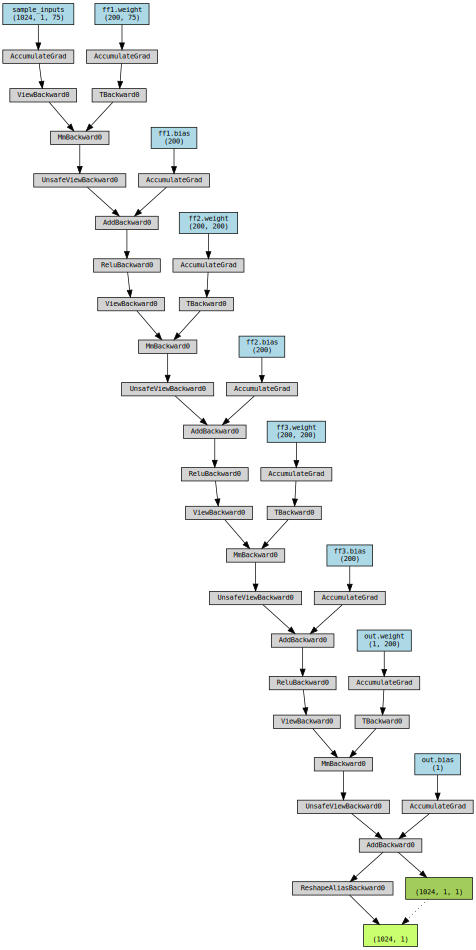

In [ ]:
# Visualize model with torchviz
sample_inputs = next(iter(train_loader))[0].requires_grad_(True)
sample_y = model_ff(sample_inputs.to(device))
make_dot(sample_y, params=dict(list(model_ff.named_parameters())+[('sample_inputs', sample_inputs)]))

In [ ]:
summary(model_ff, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            --                        --
├─Linear: 1-1                            [1024, 200]               15,200
├─Linear: 1-2                            [1024, 200]               40,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (M): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

### TODO#4

Explain why the first linear layer has number of parameters = 15200

**Ans:** Weight 75*200 and Bias 200

# Training

In [ ]:
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

wandb: Currently logged in as: anon1859 (use `wandb login --relogin` to force relogin)


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9241
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6597
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9207
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6596
Saving new best model..
Training epoch 3...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9196
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6580
Saving new best model..
Training epoch 4...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9193
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6579
Saving new best model..
Training epoch 5...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9192
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6575
Saving new best model..
Training epoch 6...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9188
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6580
Training epoch 7...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9186
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6569
Saving new best model..
Training epoch 8...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9182
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6564
Saving new best model..
Training epoch 9...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9184
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6565
Training epoch 10...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9181
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6569



lr,██▂▂▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▁▁▁
val_loss,██▄▄▃▄▂▁▁▂
lr,0.0001
train_loss,1.91809
val_loss,1.65693


Finished Training


### TODO#5

Plot loss and val_loss as a function of epochs.

Text(0, 0.5, 'Loss')

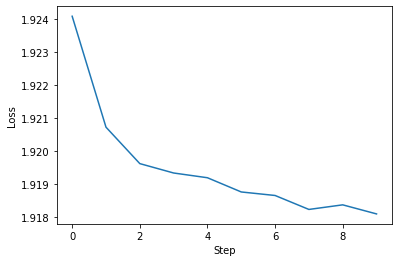

In [ ]:
plt.plot(train_losses)
plt.xlabel("Step")
plt.ylabel("Loss")

Text(0, 0.5, 'Val Loss')

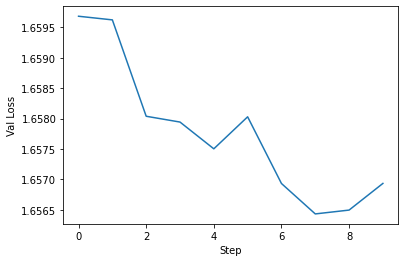

In [ ]:
plt.plot(val_losses)
plt.xlabel("Step")
plt.ylabel("Val Loss")

### TODO#6

When does the model start to overfit?

**Ans:** From the training and valldation loss graphs, the model is seem to overfit when after 8th epoch due to the train loss is slowly reduced while validation is slightly increased. On the other hand, the scale of the graph is a illusion for this inpretation since the value of the difference of the validation losses in each epoch is very small. The very small might be happended by the minibatch training. Therefore, the model is not overfit. 

### TODO#7

Plot the learning rate as a function of the epochs.

Text(0, 0.5, 'LR')

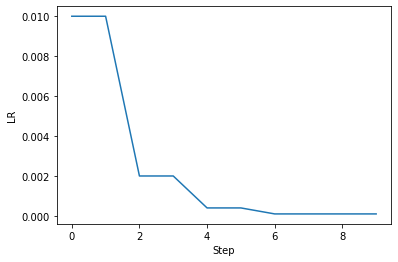

In [ ]:
plt.plot(learning_rates)
plt.xlabel("Step")
plt.ylabel("LR")

### TODO#8

What makes the learning rate change?
(hint: try to understand the scheduler [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html))


**Ans:** If the loss of traning is no longer improve by a scale of the thradshold, the learning rate will be reduced by factor.

# Load Model

Use the code snippet below to load the model you just trained

In [ ]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")

Loaded epoch 7 model


# A more complex scheduling

The scheduler can be very complicated and you can write your own heuristic for it.

### TODO#9

Implement a custom learning rate scheduler that behaves like the following graph.

You might want to learn how to use [PyTorch's built-in learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) in order to build your own.

Learning rate should be function of epoch.

![](https://raw.githubusercontent.com/pjumruspun/ComProg2021-Workshop/main/graph.png)

In [ ]:
# Implement scheduler here
class MyScheduler():
    def __init__(self, optimizer: torch.optim.Optimizer):
      self.optimizer = optimizer
      optimizer.param_groups[0]['lr'] = 0.0001

    def step(self, epoch):
      # Changes the learning rate here
      if epoch < 3:
        lr = epoch*0.0003+0.0001
      elif epoch < 6:
        lr = -(epoch-3)*0.0005/3+0.0010
      elif epoch < 7:
        lr = (epoch-6)*0.0005+0.0005
      elif epoch < 9:
        lr = -(epoch-7)*0.0009/2+0.0010
      else :
        lr = 0.0001

      optimizer.param_groups[0]['lr'] = lr

In [ ]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters())
my_scheduler = MyScheduler(optimizer)

In [ ]:
# Now train with your scheduler

train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    my_scheduler.step(epoch)
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

Training epoch 1...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9187
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6570
Saving new best model..
Training epoch 2...
Current LR: 0.00039999999999999996


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9187
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6562
Saving new best model..
Training epoch 3...
Current LR: 0.0007


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9186
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6575
Training epoch 4...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9184
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6567
Training epoch 5...
Current LR: 0.0008333333333333334


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9187
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6565
Training epoch 6...
Current LR: 0.0006666666666666668


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9181
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6563
Training epoch 7...
Current LR: 0.0005


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9176
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6565
Training epoch 8...
Current LR: 0.001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9179
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6557
Saving new best model..
Training epoch 9...
Current LR: 0.00055


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9179
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6560
Training epoch 10...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9170
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6560



lr,▁▃▆█▇▅▄█▄▁
train_loss,██▇▇█▆▃▄▅▁
val_loss,▆▃█▅▄▃▄▁▂▂
lr,0.0001
train_loss,1.91697
val_loss,1.65599


Finished Training


# [Optional] Wandb #

You should now have a project in wandb with the name `precipitation-nowcasting`, which you should see the latest run you just finished inside the project. If you look into the run, you should be able to see plots of learning rate, train loss, val loss in the `Charts` section. Below it should be `Gradients` and `Parameters` section.

# Wandb Observation #

### Optional TODO#1 

Write your own interpretation of the logs from this example. A simple sentence or two for each section is sufficient.

**Your answer:** The number of zero-gradient variable tends to increase. The parameters have minor change as long as it continue run.

# Evaluation

In [ ]:
################################################################################
# TODO#10:                                                                     #
# Write a function to evaluate your model. Your function must predicts         #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: Read how to use PyTorch's MSE Loss                                     #
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    wandb.init()
    model.eval()
    with torch.no_grad():
      losses = []
      for i, (inputs, y_true) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        y_pred = model(inputs)
        loss = loss_fn(y_pred, y_true)

        losses.append(loss)
      mse = torch.stack(losses).mean()
    model.train()
    return mse

In [ ]:
# We will use majority rule as a baseline.
def majority_baseline(label_set):
    unique, counts = np.unique(label_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    label_set = label_set.reshape(-1,1)
    for r in label_set:
        baseline += (majority - r) ** 2 / len(label_set)
    return baseline

In [ ]:
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))

baseline
train [1.94397725]
validate [1.6746546]


In [ ]:
print('FF-model')
print('train', evaluate(train_loader, model_ff).item())
print('validate', evaluate(val_loader, model_ff).item())

FF-model


  0%|          | 0/1121 [00:00<?, ?it/s]

train 1.9171104431152344


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.6559935808181763


# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

To access PyTorch's dropout, use `nn.Dropout`. Read more about PyTorch's built-in Dropout layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [ ]:
################################################################################
# TODO#11:                                                                     #
# Write a feedforward model with dropout                                       #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class DropoutFeedForwardNN(nn.Module):
  def __init__(self, hidden_size = 200, drop_out_rate=0.2):
    super(DropoutFeedForwardNN, self).__init__()
    self.ff1 = nn.Linear(75, hidden_size)
    self.ff2 = nn.Linear(hidden_size, hidden_size)
    self.ff3 = nn.Linear(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, 1)
    self.drop_out = nn.Dropout(p=drop_out_rate)
  def forward(self, x):
    hd1 = F.relu(self.ff1(x))
    hd1 = self.drop_out(hd1)
    hd2 = F.relu(self.ff2(hd1))
    hd2 = self.drop_out(hd2)
    hd3 = F.relu(self.ff3(hd2))
    hd3 = self.drop_out(hd3)
    y = self.out(hd3)
    return y.reshape(-1, 1)

In [ ]:
# Hyperparameters and other configs
config = {
    'architecture': 'dropout-feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 0,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_dff = DropoutFeedForwardNN(hidden_size=config['hidden_size'])
model_dff = model_dff.to(device)
optimizer = torch.optim.Adam(model_dff.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

In [ ]:
################################################################################
# TODO#12:                                                                     #
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_dff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_dff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_dff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_dff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_dff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_dff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_drop_out_ff.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training ff dropout


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9243
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6585
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9212
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6593
Training epoch 3...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9210
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6580
Saving new best model..
Training epoch 4...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9201
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6572
Saving new best model..
Training epoch 5...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9197
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6574
Training epoch 6...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9193
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6565
Saving new best model..
Training epoch 7...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9191
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6570
Training epoch 8...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9190
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6566
Training epoch 9...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9190
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6569
Training epoch 10...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9188
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6567



lr,██▂▂▂▁▁▁▁▁
train_loss,█▄▄▃▂▂▁▁▁▁
val_loss,▆█▅▃▃▁▂▁▂▁
lr,0.0001
train_loss,1.91876
val_loss,1.65668


Finished Training


### TODO#13

Plot the losses and MSE of the training and validation as before. Evaluate the dropout model's performance

Text(0, 0.5, 'Loss')

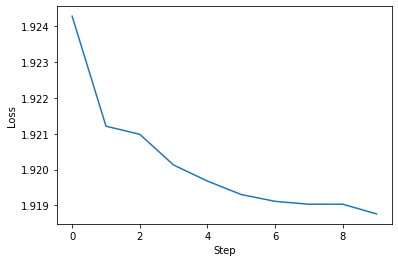

In [ ]:
# Plot here
plt.plot(train_losses)
plt.xlabel("Step")
plt.ylabel("Loss")

Text(0, 0.5, 'Val Loss')

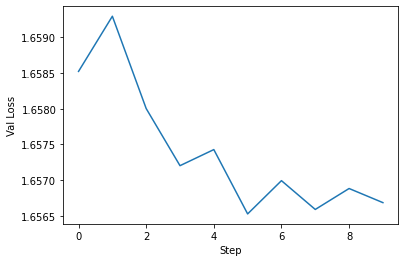

In [ ]:
# Evaluate
plt.plot(val_losses)
plt.xlabel("Step")
plt.ylabel("Val Loss")

# Convolution Neural Networks
Now let's try to incorporate the grid sturcture to your model. Instead of passing in vectors, we are going to pass in the 5x5 grid into the model (5lat x 5long x 3channel). You are going to implement you own 2d-convolution neural networks with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Conv2DNN                                 --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
==========================================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read PyTorch documentation to see the list of available layers and options you can use.                         

In [ ]:
################################################################################
# TODO#14:                                                                     #
# Complete the code for preparing data for training CNN                        #
# Input for CNN should not have time step.                                     #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_CNN(x_train, y_train, x_val, y_val):
    x_train_CNN = x_train.reshape((-1, 5, 5, 3))
    x_train_CNN = np.moveaxis(x_train_CNN, -1, 1)
    y_train_CNN = y_train.reshape((-1, 1))
    x_val_CNN = x_val.reshape((-1, 5, 5, 3))
    x_val_CNN = np.moveaxis(x_val_CNN, -1, 1)
    y_val_CNN = y_val.reshape((-1, 1))
    x_test_CNN = x_test.reshape((-1, 5, 5, 3))
    x_test_CNN = np.moveaxis(x_test_CNN, -1, 1)
    y_test_CNN = y_test.reshape((-1, 1))

    return x_train_CNN, y_train_CNN, x_val_CNN, y_val_CNN, x_test_CNN, y_test_CNN

x_train_CNN, y_train_CNN, x_val_CNN, y_val_CNN, x_test_CNN, y_test_CNN = preprocess_for_CNN(x_train, y_train, x_val, y_val)
print(x_train_CNN.shape, y_train_CNN.shape)
print(x_val_CNN.shape, y_val_CNN.shape)
print(x_test_CNN.shape, y_test_CNN.shape)

(1147740, 3, 5, 5) (1147740, 1)
(464195, 3, 5, 5) (464195, 1)
(558575, 3, 5, 5) (558575, 1)


In [ ]:
class RainfallDatasetCNN(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.width = x.shape[2]
        self.height = x.shape[3]
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        for i in range(x.shape[0]):
          x[i] = self.normalizer[i].transform(x[i].reshape(1, -1)).reshape(self.width, self.height) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [ ]:
normalizers = [0, 0, 0] 
normalizers[0] = normalizer_std(x_train_CNN[:,0,:,:].reshape(-1, x_train_CNN.shape[2] * x_train_CNN.shape[3])) 
normalizers[1] = normalizer_std(x_train_CNN[:,1,:,:].reshape(-1, x_train_CNN.shape[2] * x_train_CNN.shape[3])) 
normalizers[2] = normalizer_std(x_train_CNN[:,2,:,:].reshape(-1, x_train_CNN.shape[2] * x_train_CNN.shape[3])) 

train_dataset = RainfallDatasetCNN(x_train_CNN, y_train_CNN, normalizers)
val_dataset = RainfallDatasetCNN(x_val_CNN, y_val_CNN, normalizers)
test_dataset = RainfallDatasetCNN(x_test_CNN, y_test_CNN, normalizers)

(1147740, 3, 5, 5)
(1147740, 1)
(464195, 3, 5, 5)
(464195, 1)
(558575, 3, 5, 5)
(558575, 1)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

In [ ]:
################################################################################
# TODO#15:                                                                     #
# Write a PyTorch convolutional neural network model.                          #
# You might want to use the layer torch.flatten somewhere                      #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

class CNN(nn.Module):
  def __init__(self, hidden_size = 200, kernel_size = 3, channel = 3):
    super(CNN, self).__init__()
    self.conv2d = nn.Conv2d(channel, hidden_size, kernel_size)
    size_feature_map = 5-kernel_size+1
    self.ff2 = nn.Linear(hidden_size*size_feature_map*size_feature_map, hidden_size)
    self.ff3 = nn.Linear(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = self.conv2d(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.ff2(x))
    x = F.relu(self.ff3(x))
    y = self.out(x)
    return y.reshape(-1, 1)

In [ ]:
# Hyperparameters and other configs
config = {
    'architecture': 'CNN',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 0,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_CNN = CNN(hidden_size=config['hidden_size'])
model_CNN = model_CNN.to(device)
optimizer = torch.optim.Adam(model_CNN.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

In [ ]:
summary(model_CNN, input_size=(1024, 3, 5, 5))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
Total mult-adds (M): 461.83
Input size (MB): 0.31
Forward/backward pass size (MB): 18.03
Params size (MB): 1.62
Estimated Total Size (MB): 19.96

In [ ]:
################################################################################
# TODO#16:                                                                     #
# Complete the code to train your cnn model                                    #
################################################################################
print('start training conv2d')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_CNN, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_CNN.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_CNN(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_CNN.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_CNN(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_CNN.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_CNN.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training conv2d


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 2.2861
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6578
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 529.3535
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.8125
Training epoch 3...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9372
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6624
Training epoch 4...
Current LR: 0.0004


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9266
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6603
Training epoch 5...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9253
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6819
Training epoch 6...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9256
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6601
Training epoch 7...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9273
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6607
Training epoch 8...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9302
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6682
Training epoch 9...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9317
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6810
Training epoch 10...
Current LR: 0.0001


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9314
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6601



lr,██▂▁▁▁▁▁▁▁
train_loss,▁█▁▁▁▁▁▁▁▁
val_loss,▁█▁▁▂▁▁▁▂▁
lr,0.0001
train_loss,1.93141
val_loss,1.66009


Finished Training


Text(0, 0.5, 'Loss')

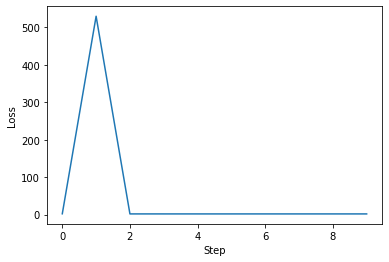

In [ ]:
# Plot losses
plt.plot(train_losses)
plt.xlabel("Step")
plt.ylabel("Loss")

Text(0, 0.5, 'Val Loss')

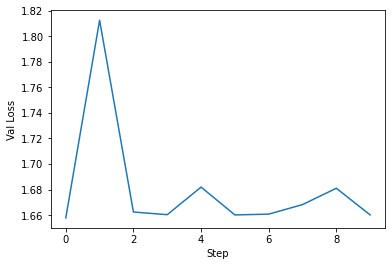

In [ ]:
# Evaluate
plt.plot(val_losses)
plt.xlabel("Step")
plt.ylabel("Val Loss")

# Gated Recurrent Units

Now, you want to add time steps into your model. Recall the original data has 5 time steps per item. You are going to pass in a data of the form 5 timesteps x 75data. This can be done using a GRU layer. Implement you own GRU network with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
GRUModel                                 --                        --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
==========================================================================================
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
```


These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         
The result should be better than the feedforward model and at least on par with your CNN model.    

Do consult PyTorch documentation on how to use [GRUs](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).


In [ ]:
################################################################################
# TODO#17:                                                                     #
# Complete the code for preparing data for training GRU                        #
# GRU's input should has 3 dimensions.                                         #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def preprocess_for_GRU(x_train, y_train, x_val, y_val):
    x_train_GRU = x_train.reshape((-1, 5, 5*5*3))
    y_train_GRU = y_train.reshape((-1, 5, 1))
    x_val_GRU = x_val.reshape((-1, 5, 5*5*3))
    y_val_GRU = y_val.reshape((-1, 5, 1))
    x_test_GRU = x_test.reshape((-1, 5, 5*5*3))
    y_test_GRU = y_test.reshape((-1, 5, 1))

    return x_train_GRU, y_train_GRU, x_val_GRU, y_val_GRU, x_test_GRU, y_test_GRU

x_train_GRU, y_train_GRU, x_val_GRU, y_val_GRU, x_test_GRU, y_test_GRU = preprocess_for_GRU(x_train, y_train, x_val, y_val)
print(x_train_GRU.shape, y_train_GRU.shape)
print(x_val_GRU.shape, y_val_GRU.shape)
print(x_test_GRU.shape, y_test_GRU.shape)

(229548, 5, 75) (229548, 5, 1)
(92839, 5, 75) (92839, 5, 1)
(111715, 5, 75) (111715, 5, 1)


In [ ]:
class RainfallDatasetGRU(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        for i in range(x.shape[0]):
          x[i] = self.normalizer[i].transform(x[i].reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [ ]:
normalizers = [0, 0, 0, 0, 0] 
normalizers[0] = normalizer_std(x_train_GRU[:,0,:].reshape(-1, x_train_GRU.shape[2])) 
normalizers[1] = normalizer_std(x_train_GRU[:,1,:].reshape(-1, x_train_GRU.shape[2])) 
normalizers[2] = normalizer_std(x_train_GRU[:,2,:].reshape(-1, x_train_GRU.shape[2])) 
normalizers[3] = normalizer_std(x_train_GRU[:,3,:].reshape(-1, x_train_GRU.shape[2]))
normalizers[4] = normalizer_std(x_train_GRU[:,4,:].reshape(-1, x_train_GRU.shape[2]))  

train_dataset = RainfallDatasetGRU(x_train_GRU, y_train_GRU, normalizers)
val_dataset = RainfallDatasetGRU(x_val_GRU, y_val_GRU, normalizers)
test_dataset = RainfallDatasetGRU(x_test_GRU, y_test_GRU, normalizers)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

(229548, 5, 75)
(229548, 5, 1)
(92839, 5, 75)
(92839, 5, 1)
(111715, 5, 75)
(111715, 5, 1)


In [ ]:
################################################################################
# TODO#18                                                                      #
# Write a PyTorch GRU model.                                                   #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class GRU(nn.Module):
  def __init__(self, hidden_size = 200, device = torch.device("cpu")):
    super(GRU, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.gru = nn.GRU(75, hidden_size)
    self.ff1 = nn.Linear(hidden_size, hidden_size)
    self.ff2 = nn.Linear(hidden_size, 1)

  def forward(self, x):
    h0 = torch.zeros((1, 5, self.hidden_size), device = device).requires_grad_()
    x, _ = self.gru(x, h0.detach())
    x = F.relu(self.ff1(x))
    x = self.ff2(x)
    return x

In [ ]:
# Hyperparameters and other configs
config = {
    'architecture': 'GRU',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 0,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

# Model
model_GRU = GRU(hidden_size=config['hidden_size'], device = device)
model_GRU = model_GRU.to(device)
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

In [ ]:
summary(model_GRU, input_size=(1024, 5, 5*5*3))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      --                        --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
Total mult-adds (M): 892.31
Input size (MB): 1.54
Forward/backward pass size (MB): 16.42
Params size (MB): 0.83
Estimated Total Size (MB): 18.79

In [80]:
################################################################################
# TODO#19                                                                      #
# Complete the code to train your gru model                                    #
################################################################################
print('start training gru')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting',
    config=config,
)

# Log parameters and gradients
wandb.watch(model_GRU, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_GRU.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_GRU(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model_GRU.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            
            # Predict
            y_pred = model_GRU(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_GRU.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, 'model_GRU.pth.tar')
    
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training gru


Training epoch 1...
Current LR: 0.0001


  0%|          | 0/225 [00:02<?, ?it/s]

Epoch 1 train loss: 1.9249
Validating epoch 1


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6772
Saving new best model..
Training epoch 2...
Current LR: 0.0001


  0%|          | 0/225 [00:01<?, ?it/s]

Epoch 2 train loss: 1.9235
Validating epoch 2


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6772
Training epoch 3...
Current LR: 0.0001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9244
Validating epoch 3


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6772
Saving new best model..
Training epoch 4...
Current LR: 0.0001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9196
Validating epoch 4


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6772
Training epoch 5...
Current LR: 0.0001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9182
Validating epoch 5


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6772
Training epoch 6...
Current LR: 0.0001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9238
Validating epoch 6


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6773
Training epoch 7...
Current LR: 0.0001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9237
Validating epoch 7


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6771
Saving new best model..
Training epoch 8...
Current LR: 0.0001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9219
Validating epoch 8


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6772
Training epoch 9...
Current LR: 0.0001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9210
Validating epoch 9


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6771
Saving new best model..
Training epoch 10...
Current LR: 0.0001


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9179
Validating epoch 10


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6772



lr,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▃▁▇▇▅▄▁
val_loss,▄▆▃▇▅█▂▇▁▄
lr,0.0001
train_loss,1.91786
val_loss,1.67717


Finished Training


Text(0, 0.5, 'Loss')

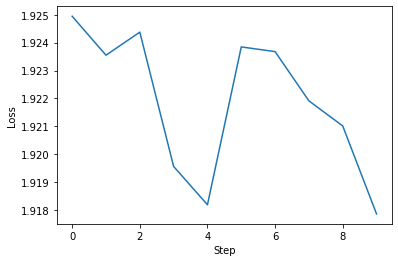

In [81]:
# Plot
plt.plot(train_losses)
plt.xlabel("Step")
plt.ylabel("Loss")

Text(0, 0.5, 'Val Loss')

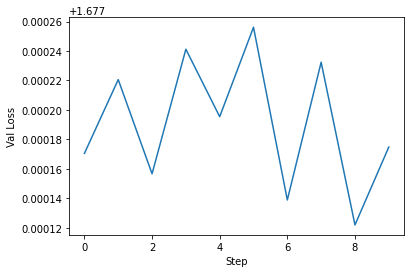

In [82]:
# Evaluate
plt.plot(val_losses)
plt.xlabel("Step")
plt.ylabel("Val Loss")

# Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find printing computation graphs helpful in debugging complicated models.    
Your model should be better than your CNN or GRU model in the previous sections.

Some ideas:

- Tune the hyperparameters
- Adding dropouts
- Combining CNN with GRUs

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [83]:
def train(config, organizer):
  train_losses = []
  val_losses = []
  learning_rates = []

  # Start wandb run
  wandb.init(
      project='precipitation-nowcasting',
      config=config,
  )

  model = organizer['model']
  optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer, 
      'min', 
      factor=config['scheduler_factor'], 
      patience=config['scheduler_patience'], 
      min_lr=config['scheduler_min_lr']
  )
  train_loader = organizer['train_loader']
  val_loader = organizer['val_loader']

  # Log parameters and gradients
  wandb.watch(organizer['model'], log='all')

  for epoch in range(config['epochs']):  # loop over the dataset multiple times
      
      # Training
      train_loss = []
      current_lr = optimizer.param_groups[0]['lr']
      learning_rates.append(current_lr)

      # Flag model as training. Some layers behave differently in training and
      # inference modes, such as dropout, BN, etc.
      model.train()

      print(f"Training epoch {epoch+1}...")
      print(f"Current LR: {current_lr}")

      for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
          # Transfer data from cpu to gpu
          inputs = inputs.to(device)
          y_true = y_true.to(device)

          # Reset the gradient
          optimizer.zero_grad()

          # Predict
          y_pred = model(inputs)
          # Calculate loss
          loss = loss_fn(y_pred, y_true)

          # Compute gradient
          loss.backward()
          
          # Update parameters
          optimizer.step()

          # Log stuff
          train_loss.append(loss)
          
      avg_train_loss = torch.stack(train_loss).mean().item()
      train_losses.append(avg_train_loss)

      print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
      
      # Validation
      model.eval()
      with torch.no_grad(): # No gradient is required during validation
          print(f"Validating epoch {epoch+1}")
          val_loss = []
          for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
              # Transfer data from cpu to gpu
              inputs = inputs.to(device)
              y_true = y_true.to(device)
              
              # Predict
              y_pred = model(inputs)

              # Calculate loss
              loss = loss_fn(y_pred, y_true)

              # Log stuff
              val_loss.append(loss)
          
          avg_val_loss = torch.stack(val_loss).mean().item()
          val_losses.append(avg_val_loss)
          print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

          # LR adjustment with scheduler
          scheduler.step(avg_val_loss)

          # Save checkpoint if val_loss is the best we got
          best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
          if avg_val_loss < best_val_loss:
              # Save whatever you want
              state = {
                  'epoch': epoch,
                  'model': model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'scheduler': scheduler.state_dict(),
                  'train_loss': avg_train_loss,
                  'val_loss': avg_val_loss,
                  'best_val_loss': best_val_loss,
              }
              
              print(f"Saving new best model..")
              torch.save(state, config['architecture']+'.pth.tar')
      output = {
          'train_loss': avg_train_loss,
          'val_loss': avg_val_loss,
          'lr': current_lr,
      }
      wandb.log(output)

  wandb.finish()
  print('Finished Training')
  output['best_val_loss'] = best_val_loss
  output['state'] = state
  return output

In [84]:
(y_train == 0).sum(), (y_train == 0).sum()+(y_train != 0).sum()

(1097546, 1147740)

In [85]:
def get_new_data_set(x, y):
  non_zero_pos = (y != 0).reshape(-1)
  zero_pos = non_zero_pos != 1
  non_zero_count = non_zero_pos.sum()
  zero_count = zero_pos.sum()
  x_non_zero = x[non_zero_pos, :]
  y_non_zero = y[non_zero_pos]
  zero_selected_pos = np.random.choice(zero_count, 0, replace = False)
  x_zero = x[zero_pos, :]
  x_zero = x_zero[zero_selected_pos, :]
  y_zero = y[zero_pos]
  y_zero = y_zero[zero_selected_pos]

  return np.concatenate((x_zero, x_non_zero), axis=0), np.concatenate((y_zero, y_non_zero), axis=0)

In [86]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)

x_train_ff, y_train_ff = get_new_data_set(x_train_ff, y_train_ff)

x_train_ff = pca.fit_transform(x_train_ff)
x_val_ff = pca.transform(x_val_ff)
x_test_ff = pca.transform(x_test_ff)

print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(50194, 5) (50194, 1)
(464195, 5) (464195, 1)
(558575, 5) (558575, 1)


In [87]:
class RainfallDatasetFF2(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        #x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [88]:
normalizer = normalizer_std(x_train_ff) 

train_dataset = RainfallDatasetFF2(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF2(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF2(x_test_ff, y_test_ff, normalizer)

(50194, 5)
(50194, 1)
(464195, 5)
(464195, 1)
(558575, 5)
(558575, 1)


In [89]:
train_loader_ff2 = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_ff2 = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_ff2 = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

In [90]:
class FeedForwardNN2(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN2, self).__init__()
        self.ff1 = nn.Linear(5, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.ff1(x))
        x = F.relu(self.ff2(x))
        y = F.relu(self.out(x))
        return y.reshape(-1, 1)

In [91]:
config = {
    'architecture': 'ff-pca-new-dataset',
    'lr': 0.1,
    'hidden_size': 50,
    'scheduler_factor': 0.3,
    'scheduler_patience': 0,
    'scheduler_min_lr': 5e-5,
    'epochs': 10
}

model_ff_2 = FeedForwardNN2(hidden_size=config['hidden_size'])
model_ff_2 = model_ff_2.to(device)

organizer = {
  'model' : model_ff_2,
  'train_loader' : train_loader_ff2,
  'val_loader' : val_loader_ff2
}

outcome_ff = train(config, organizer)

Training epoch 1...
Current LR: 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 train loss: 45.7372
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6721
Saving new best model..
Training epoch 2...
Current LR: 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 train loss: 44.0856
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6721
Training epoch 3...
Current LR: 0.03


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 train loss: 44.2267
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6721
Training epoch 4...
Current LR: 0.009


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 train loss: 45.2959
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6721
Training epoch 5...
Current LR: 0.0026999999999999997


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 train loss: 46.2543
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6721
Training epoch 6...
Current LR: 0.0008099999999999998


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6 train loss: 43.8785
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6721
Training epoch 7...
Current LR: 0.00024299999999999994


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 train loss: 45.4355
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6721
Training epoch 8...
Current LR: 7.289999999999998e-05


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8 train loss: 43.7232
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6721
Training epoch 9...
Current LR: 5e-05


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9 train loss: 44.3429
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6721
Training epoch 10...
Current LR: 5e-05


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10 train loss: 44.5419
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6721



lr,██▃▂▁▁▁▁▁▁
train_loss,▇▂▂▅█▁▆▁▃▃
val_loss,▁▁▁▁▁▁▁▁▁▁
lr,5e-05
train_loss,44.54188
val_loss,1.67213


Finished Training


In [ ]:
################################################################################
# TODO#20                                                                      #
# Write a function that returns your best PyTorch model. You can use anything  #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
################################################################################
# TODO#21                                                                      #
# Complete the code to train your best model                                   #
################################################################################
print('start training the best model')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


start training the best model


Val-Test Evaluation in Feed forward model + PCA

In [92]:
print('FF-PCA-model')
print('validate', evaluate(val_loader_ff2, model_ff_2).item())
print('test', evaluate(test_loader_ff2, model_ff_2).item())

FF-PCA-model


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.672129511833191


  0%|          | 0/546 [00:00<?, ?it/s]

test 1.167553186416626


In [93]:
x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)

normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train

train_dataset_ff = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset_ff = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset_ff = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

train_loader_ff = DataLoader(train_dataset_ff, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_ff = DataLoader(val_dataset_ff, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_ff = DataLoader(test_dataset_ff, batch_size=1024, shuffle=False, pin_memory=True)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


The baseline of all model.

In [94]:
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))
print('test', majority_baseline(y_test))

baseline
train [1.94397725]
validate [1.6746546]
test [1.16865877]


Val-Test Evaluation in FF-model

In [97]:
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 0,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

checkpoint = torch.load('/content/model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
loaded_model = loaded_model.to(device)
print(f"Loaded epoch {checkpoint['epoch']} model")

print('FF-model')
print('validate', evaluate(val_loader_ff, loaded_model).item())
print('test', evaluate(test_loader_ff, loaded_model).item())

Loaded epoch 7 model
FF-model


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.6556638479232788


  0%|          | 0/546 [00:00<?, ?it/s]

test 1.1597468852996826


Val-Test Evaluation in CNN Model

In [98]:
x_train_CNN, y_train_CNN, x_val_CNN, y_val_CNN, x_test_CNN, y_test_CNN = preprocess_for_CNN(x_train, y_train, x_val, y_val)

normalizers = [0, 0, 0] 
normalizers[0] = normalizer_std(x_train_CNN[:,0,:,:].reshape(-1, x_train_CNN.shape[2] * x_train_CNN.shape[3])) 
normalizers[1] = normalizer_std(x_train_CNN[:,1,:,:].reshape(-1, x_train_CNN.shape[2] * x_train_CNN.shape[3])) 
normalizers[2] = normalizer_std(x_train_CNN[:,2,:,:].reshape(-1, x_train_CNN.shape[2] * x_train_CNN.shape[3])) 

train_dataset_CNN = RainfallDatasetCNN(x_train_CNN, y_train_CNN, normalizers)
val_dataset_CNN = RainfallDatasetCNN(x_val_CNN, y_val_CNN, normalizers)
test_dataset_CNN = RainfallDatasetCNN(x_test_CNN, y_test_CNN, normalizers)

train_loader_CNN = DataLoader(train_dataset_CNN, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_CNN = DataLoader(val_dataset_CNN, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_CNN = DataLoader(test_dataset_CNN, batch_size=1024, shuffle=False, pin_memory=True)

(1147740, 3, 5, 5)
(1147740, 1)
(464195, 3, 5, 5)
(464195, 1)
(558575, 3, 5, 5)
(558575, 1)


In [101]:
config = {
    'architecture': 'CNN',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 0,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

checkpoint = torch.load('/content/model_CNN.pth.tar')
loaded_model = CNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
loaded_model = loaded_model.to(device)
print(f"Loaded epoch {checkpoint['epoch']} model")

print('CNN-model')
print('validate', evaluate(val_loader_CNN, loaded_model).item())
print('test', evaluate(test_loader_CNN, loaded_model).item())

Loaded epoch 0 model
CNN-model


  0%|          | 0/454 [00:00<?, ?it/s]

validate 1.657767415046692


  0%|          | 0/546 [00:00<?, ?it/s]

test 1.1643887758255005


val-test evaluation of GRU model

In [103]:
normalizers = [0, 0, 0, 0, 0] 
normalizers[0] = normalizer_std(x_train_GRU[:,0,:].reshape(-1, x_train_GRU.shape[2])) 
normalizers[1] = normalizer_std(x_train_GRU[:,1,:].reshape(-1, x_train_GRU.shape[2])) 
normalizers[2] = normalizer_std(x_train_GRU[:,2,:].reshape(-1, x_train_GRU.shape[2])) 
normalizers[3] = normalizer_std(x_train_GRU[:,3,:].reshape(-1, x_train_GRU.shape[2]))
normalizers[4] = normalizer_std(x_train_GRU[:,4,:].reshape(-1, x_train_GRU.shape[2]))  

train_dataset_GRU = RainfallDatasetGRU(x_train_GRU, y_train_GRU, normalizers)
val_dataset_GRU = RainfallDatasetGRU(x_val_GRU, y_val_GRU, normalizers)
test_dataset_GRU = RainfallDatasetGRU(x_test_GRU, y_test_GRU, normalizers)

train_loader_GRU = DataLoader(train_dataset_GRU, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_GRU = DataLoader(val_dataset_GRU, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_GRU = DataLoader(test_dataset_GRU, batch_size=1024, shuffle=False, pin_memory=True)

(229548, 5, 75)
(229548, 5, 1)
(92839, 5, 75)
(92839, 5, 1)
(111715, 5, 75)
(111715, 5, 1)


In [105]:
config = {
    'architecture': 'GRU',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 0,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

checkpoint = torch.load('/content/model_GRU.pth.tar')
loaded_model = GRU(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
loaded_model = loaded_model.to(device)
print(f"Loaded epoch {checkpoint['epoch']} model")

print('GRU-model')
print('validate', evaluate(val_loader_GRU, loaded_model).item())
print('test', evaluate(test_loader_GRU, loaded_model).item())

Loaded epoch 8 model
GRU-model


  0%|          | 0/91 [00:00<?, ?it/s]

validate 1.6771222352981567


  0%|          | 0/110 [00:00<?, ?it/s]

test 1.1575502157211304


val-test evaluation of CNNGRU model (The record of this training process is appeered on the another file.)

In [106]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_CNNGRU(x_train, y_train, x_val, y_val, x_test, y_test):
    x_train = x_train.reshape((-1, 5, 5, 5, 3))
    x_train = np.moveaxis(x_train, -1, 2)
    y_train = y_train.reshape((-1, 5, 1))

    x_val = x_val.reshape((-1, 5, 5, 5, 3))
    x_val = np.moveaxis(x_val, -1, 2)
    y_val = y_val.reshape((-1, 5, 1))

    x_test = x_test.reshape((-1, 5, 5, 5, 3))
    x_test = np.moveaxis(x_test, -1, 2)
    y_test = y_test.reshape((-1, 5, 1))

    return x_train, y_train, x_val, y_val, x_test, y_test

x_train_CNNGRU, y_train_CNNGRU, x_val_CNNGRU, y_val_CNNGRU, x_test_CNNGRU, y_test_CNNGRU = preprocess_for_CNNGRU(x_train, y_train, x_val, y_val, x_test, y_test)

In [107]:
class RainfallDatasetCNNGRU(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

train_dataset_CNNGRU = RainfallDatasetCNNGRU(x_train_CNNGRU, y_train_CNNGRU)
val_dataset_CNNGRU = RainfallDatasetCNNGRU(x_val_CNNGRU, y_val_CNNGRU)
test_dataset_CNNGRU = RainfallDatasetCNNGRU(x_test_CNNGRU, y_test_CNNGRU)

train_loader_CNNGRU = DataLoader(train_dataset_CNNGRU, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_CNNGRU = DataLoader(val_dataset_CNNGRU, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_CNNGRU = DataLoader(test_dataset_CNNGRU, batch_size=1024, shuffle=False, pin_memory=True)

(229548, 5, 3, 5, 5)
(229548, 5, 1)
(92839, 5, 3, 5, 5)
(92839, 5, 1)
(111715, 5, 3, 5, 5)
(111715, 5, 1)


In [108]:
class CNNGRU(nn.Module):
  def __init__(self, hidden_size = 200, kernel_size = 3, channel = 3, device = torch.device("cuda")):
    super(CNNGRU, self).__init__()
    self.device = device
    self.hidden_size = hidden_size

    self.conv2d = [nn.Conv2d(channel, hidden_size, kernel_size) for _ in range(5)]
    self.size_feature_map = 5-kernel_size+1
    self.ff1 = [nn.Linear(hidden_size*self.size_feature_map**2, 75) for _ in range(5)]
    self.gru = nn.GRU(75, hidden_size)
    self.ff2 = nn.Linear(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, 1)

  def forward(self, x):
    t = torch.empty(x.size()[0], 5, 75).to(self.device)
    for i in range(x.size()[1]):
      temp = self.conv2d[i](x[:,i])
      temp = torch.flatten(temp, 1)
      t[:,i] = F.relu(self.ff1[i](temp))
    h0 = torch.zeros((1, 5, self.hidden_size), device = device).requires_grad_()
    t, _ = self.gru(t, h0.detach())
    t = F.relu(self.ff2(t))
    t = self.out(t)
    return t

In [111]:
config = {
    'architecture': 'ฉ์์ขGRU',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 0,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

checkpoint = torch.load('/content/cnn-gru-2.pth.tar')
loaded_model = CNNGRU(device = device) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
loaded_model = loaded_model.to(device)
print(f"Loaded epoch {checkpoint['epoch']} model")

print('CNNGRU-model')
print('validate', evaluate(val_loader_CNNGRU, loaded_model).item())
print('test', evaluate(test_loader_CNNGRU, loaded_model).item())

Loaded epoch 4 model
CNNGRU-model


  0%|          | 0/91 [00:00<?, ?it/s]

validate 1.6862152814865112


  0%|          | 0/110 [00:00<?, ?it/s]

test 1.167797565460205


In [112]:
# Evaluate best model on validation and test set


In [113]:
# Also evaluate your fully-connected model and CNN/GRU model on the test set.


To get full credit for this part, your best model should be better than the previous models on the **test set**. 

### TODO#22

Explain what helped and what did not help here

**Ans:** 
- Model complexity increasing doesn't effect the performance such as adding hidden layer and adding number of neuron in each layer.
- Extract spatial infomation (CNN) doesn't effect the performance since the size of each segmented grid is very small (5*5). Therefore, the performance of feed forward's performance doesn't different from CNN's
- Extract temporal infomation (GRU) doesn't effect the performance because  although the 5 length decomposed PCA eigenvectors to cover 99% variance of data that could be interpred as a 5 length vector but most of ys are zero. If the model is trying to answer all prediction to zero, the lost of the prediction is will very small.



# [Optional] Augmentation using data loader

### Optional TODO#2

Implement a new dataloader on your best model that will perform data augmentation. Try adding noise of zero mean and variance of $10e^{-2}$.

Then, train your model.

In [ ]:
# Write Dataset/DataLoader with noise here


In [ ]:
print('start training the best model with noise')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
# Evaluate the best model trained with noise on validation and test set
